# Introduction
 
Major music streaming services, such as Spotify and Pandora, find music for consumers that cater to their individual tastes. For example, Spotify can create radios for specific artists, albums, or tracks to help users find new music based on their listening history. How does Spotify figure this out? Such companies do this by using data to predict the type of music that listeners would enjoy. With this data, Spotify can predict the type of music that best suits the user.

Gathering data based on user preferences is also useful for determining which features of a song make a track popular. Using already known data, one could pinpoint what exactly makes pop music, for example, so popular because each track comes with information on the key, tempo, energy, etc. The fact that this information is available is lucrative because artists and musicians could find out what kind of sounds could elicit a favorable response. This would help people in the music industry discover current music trends.


# Members and Work Distribution

* A13301736 
    * Data Cleaning/Pre-Processing
        * Cleaned Data into dataframe for data visualization
    * Data Visualization 
        * Created graphs for song attributes
    * Code debugging
   
   
   
* A13564644
    * Data Description
    * Data Visualization (distribution plots and highlighted graphs)
    * Data Analysis
    * Privacy and Ethics Consideration
    
    
    
* A12351770
    * Organized and led the group
    * Introduction and Background
    * Data Analysis
    * Discussion
    
    
    
* A12218724
    * Helped with data cleaning and data analysis
    * Debugging
    
    
* A14222539
    * Helped with data retriveal and putting it into a csv file
    * Found correlation coefficient for each attribute
    * Found total of streams for each unique artists
    * Analysis
    
    
    
* A12301049
    * Introduction and Background
    * Data Analysis
    * Conclusion
    
    
    

# Background Information

Our research question involves the use of music’s audio features, so we will need to understand them first. They are listed below:

__Pitch class notation__: A method to classify the 12 pitches from integers 0 to 11. 
 
|__Pitch class__| __Tonal counterpart__ |
|-----------|-------------------|
|     0     |        C          |
|     1     |      C#, D♭       |
|     2     |        D          |
|     3     |      D#, E♭       |
|     4     |        E          |
|     5     |        F          |
|     6     |      F#, G♭       |
|     7     |        G          |
|     8     |      G#, A♭       |
|     9     |        A          |
|    10     |      A#, B♭       |
|    11     |        B          |


<img src="./audio_features_image.JPG"/>

Table taken from: https://developer.spotify.com/web-api/get-audio-features/


# Research Question

Is there going to be a correlation between certain audio attributes and position on the top charts? If there is a correlation, which features of a song make it more popular? Such features include danceability, energy, key, loudness, mode, speechiness, acousticness, etc. as shown in the above chart.


# Hypothesis

We predict that songs that make the top charts will have certain features in common over others. More specifically, we expect tracks with higher valence, energy, and danceability to be more likely to hold a higher position on the charts.


# Privacy and Ethics

In terms of Ethics and Privacy of the research, it is appropriate to use the dataset we found from “kworb.net” in our project. Kworb.net is a personal website created by a data scientist whose nickname is Kworb. Kworb accumulates data on top rated music through Spotify Charts overtime. Since we consider to use the historical data on top rated music in our research, and Spotify Charts only provides publicly available data on top rated music for the most recent year, we didn’t download data from Spotify Charts directly. Instead, we messaged the owner of “kworb.net” through Twitter and got his consent on web scraping the data posted on his website. 

There might be potential biases in our dataset since the definition of “Top Hits” varies. In our dataset, the popularity of one music piece is based on its number of streams on Spotify. Therefore, our predictions after analysis will more likely fit the taste of the Spotify users. However, since Spotify is a widely used music player, which aims to predict users’ preferences for music. Spotify users construct a good sample providing data representing the music interests of the general population.


# Data Origin

Chart from http://kworb.net/spotify/country/global_daily_totals.html

# Imports

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} beautifulsoup4

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.6
  latest version: 4.5.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [1]:
import pandas as pd
import numpy as np
import requests
import bs4
import urllib.request
from urllib.request import urlopen
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import patsy
from scipy.stats import ttest_ind
import statsmodels.api as sm
import seaborn as sns

/Users/connie/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning

__Starting to scrap chart (scraped 2/27/2018)__

chart covers from 2014/8/10 to 2018/02/26
    
- pos = position of song
- artist_title = artist and song title
- days = days since song release
- t10 = days on top10 chart
- pk = peak position
- total = total number of streams

In [ ]:
url = "http://kworb.net/spotify/country/global_daily_totals.html"

In [ ]:
#extract the data from the table into lists

html = requests.get(url).content
soup = BeautifulSoup(html, 'html.parser')

#getting the table and set into dataframe df
df_list = pd.read_html(html)
df = df_list[-1]

In [ ]:
#drop '(x?)' and 'PkStreams'
df = df.drop(['(x?)', 'PkStreams'], axis=1)

#drop the rows b/c have no attached song
df = df[df['Artist and Title']!="Jenny Duncan -"]
df = df[df['Artist and Title']!="Daniel Marcy -"]


In [ ]:
#split artist and title into two separate columns
s = " Artist - Song - Title"
s.split(" - ",1)

df_artist = []
df_song = []
for row in df['Artist and Title']:
    temp = row.split(' - ',1)
    if len(temp)==2:
        df_artist.append(temp[0])
        df_song.append(temp[1])
    else:
        print(temp[0])
        
df['Artist'] = df_artist
df['Song'] = df_song

#srop the Artist and Title column
df = df.drop(['Artist and Title'], axis=1)

#reset indices
df = df.reset_index(drop=True)

#reorder columns
df = df[['Artist', 'Song', 'Days', 'T10', 'Pk', 'Total']]

### Getting the Spotify ID for each song

After retrieving id, will merge with dataframe df

In [ ]:
#getting links for the songs
links=[]
for a in soup.find_all('a', href=True):
    #for each text
    if a.text:
        #if its corresponding link has "track" in it add to links
        if "track" in a['href']:
            links.append(a['href'])

links_df = pd.DataFrame()
links_df['id'] = links

In [ ]:
#extract the Spotify ID
#url takes for ../tracks/<SPOTIFY ID>.html
for i in range(0, len(links_df.index)):
    links_df['id'][i] = links_df['id'][i][9:-5]

In [ ]:
#merge links_df with df
df = df.join(links_df)

### Adding Features to Table
Features
- acousticness
- danceability
- duration_ms : duration of song in terms of milliseconds
- energy
- instrumentalness
- key (C, D, E, F, G, A, B, etc)
- liveness
- loudness
- mode (major, minor)
- speechiness
- tempo
- time_signature
- valence

In [ ]:
import requests
import json
from bs4 import BeautifulSoup

In [ ]:
#adding the attributes columns to df
df['acousticness']=np.nan
df['danceability']=np.nan
df['duration_ms']=np.nan
df['energy']=np.nan
df['instrumentalness']=np.nan
df['key']=np.nan
df['liveness']=np.nan
df['loudness']=np.nan
df['mode']=np.nan
df['speechiness']=np.nan
df['tempo']=np.nan
df['time_signature']=np.nan
df['valence']=np.nan

In [ ]:
#May need to refresh token if need to redo table
TOKEN = "BQAoK4ijGMISlKLdojGyxaZ3NoGM4JG7uUNreZZlmO2KlsDxsxYpSI57RwPSXCX2T_9Q5Clf3X6oSqrEeZn4STPAZUuybVeB5mj0f42bL3-NgFPa3SFVNzpUvGPoDTpNJ-8aqzZZitI"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
i = 0
parsed={}

for id in df['id']:
    
    #api for to retrieve audio features
    url2 = "https://api.spotify.com/v1/audio-features/{}".format(id)
    
    #get the json file from the url with the current id
    r = requests.get(url2, headers=headers)
    parsed = json.loads(r.text)
    
    #load each attribute's value into its corrisponding column in the table    
    df.loc[i:,('acousticness')]=parsed['acousticness']
    df.loc[i:,('danceability')]=parsed['danceability']
    df.loc[i:,('duration_ms')]=parsed['duration_ms']
    df.loc[i:,('energy')]= parsed['energy']
    df.loc[i:, ('instrumentalness')]=parsed['instrumentalness']
    df.loc[i:, ('key')]=parsed['key']
    df.loc[i:,('liveness')]=parsed['liveness']
    df.loc[i:, ('loudness')]=parsed['loudness']
    df.loc[i:, ('mode')]=parsed['mode']
    df.loc[i:, ('speechiness')]=parsed['speechiness']
    df.loc[i:, ('tempo')]=parsed['tempo']
    df.loc[i:, ('time_signature')]=parsed['time_signature']
    df.loc[i:, ('valence')]=parsed['valence']
    
    #iterate to i
    i += 1

In [ ]:
#save to csv file
df.to_csv('musicdata.csv')

# Data Visualization and Analysis

In [2]:
#maybe to avoid reruning all the data cleaning again
Data_df = pd.read_csv('musicdata.csv')
Data_df.index += 1
Data_df = Data_df.drop('Unnamed: 0', axis=1)
Data_df.index.name='Pos'

In [4]:
Data_df.head()

,Artist,Song,Days,T10,Pk,Total,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
Pos,,,,,,,,,,,,,,,,,,,,
1,Ed Sheeran,Shape of You,416,237.0,1,1608708960,7qiZfU4dY1lWllzX7mPBI3,0.58100,0.825,233713,0.652,0.00000,1,0.0931,-3.183,0,0.0802,95.977,4,0.931
2,Drake,One Dance,682,187.0,1,1393021898,1xznGGDReH1oQq0xzbwXa3,0.00784,0.791,173987,0.619,0.00423,1,0.3510,-5.886,1,0.0532,103.989,4,0.371
3,The Chainsmokers,Closer,575,191.0,1,1199158995,7BKLCZ1jbUBVqRi2FVlTVw,0.41400,0.748,244960,0.524,0.00000,8,0.1110,-5.599,1,0.0338,95.010,4,0.661
4,Luis Fonsi,Despacito - Remix,315,140.0,1,989199762,5CtI0qwDJkDQGwXD1H1cLb,0.22900,0.694,228827,0.815,0.00000,2,0.0924,-4.328,1,0.1200,88.931,4,0.813
5,Ed Sheeran,Thinking Out Loud,1203,156.0,1,952427633,34gCuhDGsG4bRPIf9bb02f,0.47400,0.781,281560,0.445,0.00000,2,0.1840,-6.061,1,0.0295,78.998,4,0.591


In [5]:
Data_df.describe(include="all")

,Artist,Song,Days,T10,Pk,Total,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,3144,3144,3144.000000,216.000000,3144.000000,3.144000e+03,3144,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000
unique,884,2931,NaN,NaN,NaN,NaN,3144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Drake,Santa Baby,NaN,NaN,NaN,NaN,3d9JucRI60arArgQXqtfjJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,80,5,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,75.712786,57.486111,98.166349,5.789419e+07,NaN,0.217557,0.634339,220909.841921,0.641594,0.019042,5.232824,0.185346,-6.699220,0.605280,0.106440,120.550897,3.954835,0.469787
std,NaN,NaN,130.143358,52.971689,58.648079,1.328688e+08,NaN,0.260463,0.152971,52888.530295,0.194347,0.097839,3.650826,0.143195,3.027735,0.488868,0.109012,28.136597,0.322843,0.227066
min,NaN,NaN,1.000000,1.000000,1.000000,1.153820e+05,NaN,0.000012,0.000000,36160.000000,0.027900,0.000000,0.000000,0.016200,-34.475000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,2.750000,8.000000,50.750000,9.672105e+05,NaN,0.024700,0.539000,192366.000000,0.518750,0.000000,1.000000,0.096200,-7.935750,0.000000,0.039475,99.757000,4.000000,0.293000
50%,NaN,NaN,13.000000,43.000000,100.000000,5.233768e+06,NaN,0.105000,0.649500,214860.500000,0.673000,0.000000,5.000000,0.128000,-6.061000,1.000000,0.059000,119.999000,4.000000,0.452500
75%,NaN,NaN,93.250000,93.000000,148.000000,4.395588e+07,NaN,0.317000,0.745000,242260.500000,0.791000,0.000102,8.000000,0.232250,-4.725750,1.000000,0.127000,137.915750,4.000000,0.644000


### Total Streams for Each Artist

In [72]:
Data_artist = Data_df
x = {}
for index, row in Data_artist.iterrows():
    if row['Artist'] not in x:
        x[row['Artist']] = row['Total']
    else:
        x[row['Artist']] += row['Total']
y = sorted(x, key=x.get, reverse=True)
for artist in y:
    print(artist + ": " + str(x[artist]))

Drake: 7004238768
Ed Sheeran: 6861503810
The Chainsmokers: 4529379798
The Weeknd: 4105021228
Justin Bieber: 3911889093
Calvin Harris: 3361306430
Major Lazer: 2810351251
Post Malone: 2491808655
Kygo: 2462503463
Shawn Mendes: 2447626607
Kendrick Lamar: 2312149468
Ariana Grande: 2294558580
Maroon 5: 2212531798
Sia: 2077779662
Luis Fonsi: 2012032899
Imagine Dragons: 1961659086
Twenty One Pilots: 1882669331
Charlie Puth: 1871725487
Rihanna: 1811721230
ZAYN: 1784761107
J Balvin: 1778308843
Selena Gomez: 1772165778
Sam Smith: 1744892483
Clean Bandit: 1713401046
David Guetta: 1713169920
Bruno Mars: 1581721230
DJ Snake: 1534949568
Jonas Blue: 1526017092
Jason Derulo: 1510061596
Martin Garrix: 1508891713
Coldplay: 1486335367
Adele: 1410363184
Camila Cabello: 1307145873
DJ Khaled: 1303395026
Avicii: 1289499991
Zara Larsson: 1279565974
Fifth Harmony: 1274599887
Migos: 1272706843
Hailee Steinfeld: 1257799169
G-Eazy: 1190052461
Future: 1176491435
Alan Walker: 1100197676
Lil Uzi Vert: 1058335723
Robi

Axel Wikner: 4450955
Norlie & KKV: 4408558
M.O: 4375229
Duke Dumont: 4288583
Missy Elliott: 4264039
187 Strassenbande: 4216107
Luny Tunes: 4211340
Birdy: 4193264
Wale: 4159633
Jack & Jack: 4134345
Journey: 4129181
Danny Saucedo: 4107183
Diana Krall: 4089012
Leonard Cohen: 4059542
DJ Jonathan: 4049143
Slade: 4028020
Aloe Blacc: 4014195
Tom Petty and the Heartbreakers: 3993767
Emil Berg: 3891647
Cobra Starship: 3874225
Jona Lewie: 3814288
Tom Walker: 3750683
Nav: 3718388
Céline Dion: 3660918
Carnage: 3623112
Loïc Nottet: 3603086
Bring Me The Horizon: 3588724
Alicia Keys: 3580988
Soundgarden: 3539542
Sigma: 3536966
Allyawan: 3528074
Eagles: 3453177
Beck: 3433252
Joakim Lundell: 3393348
Kim Cesarion: 3351620
The Wombats: 3340995
Juanes: 3331156
Emeli Sandé: 3298754
A$AP Mob: 3259534
Audioslave: 3156203
Lil' Kleine: 3095939
Toto: 3075275
Christina Perri: 3074553
Jamie xx: 3024136
MisterWives: 3015385
Prince: 3009532
Earth, Wind & Fire: 2977023
James TW: 2885474
Fences: 2863190
MC Loma: 2844

### Mean Values of Audio Features

A summary of all the average values for music attributes whose measuring scale ranges from zero to one

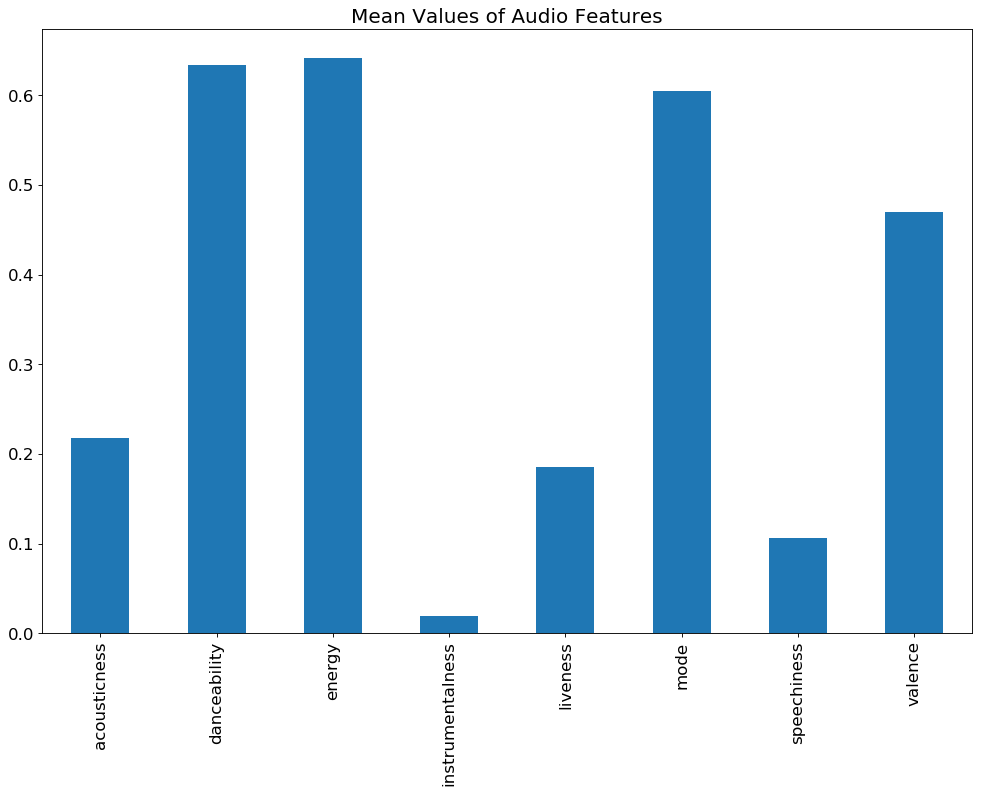

In [9]:
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(15, 10), dpi=80)
attributes = Data_df.drop(['Total','Days','T10','Pk','duration_ms', 'tempo', 'loudness', 'key', 'time_signature'], axis=1)
attributes.mean().plot.bar()
plt.title('Mean Values of Audio Features')
plt.show()

This graph suggests that most of the music on the charts tend to have relatively low acousticness,  instrumentalness, liveness, and speechiness, and high danceability, energy, mode and valence. Given the fact that Spotify is the most commonly used music player for young generation, we can infer that the music preference for the majority of the young people is upbeat over acoustic and instrumental. 

### HeatMap

Heatmap illustrating the correlation among all the music attributes for songs on Spotify

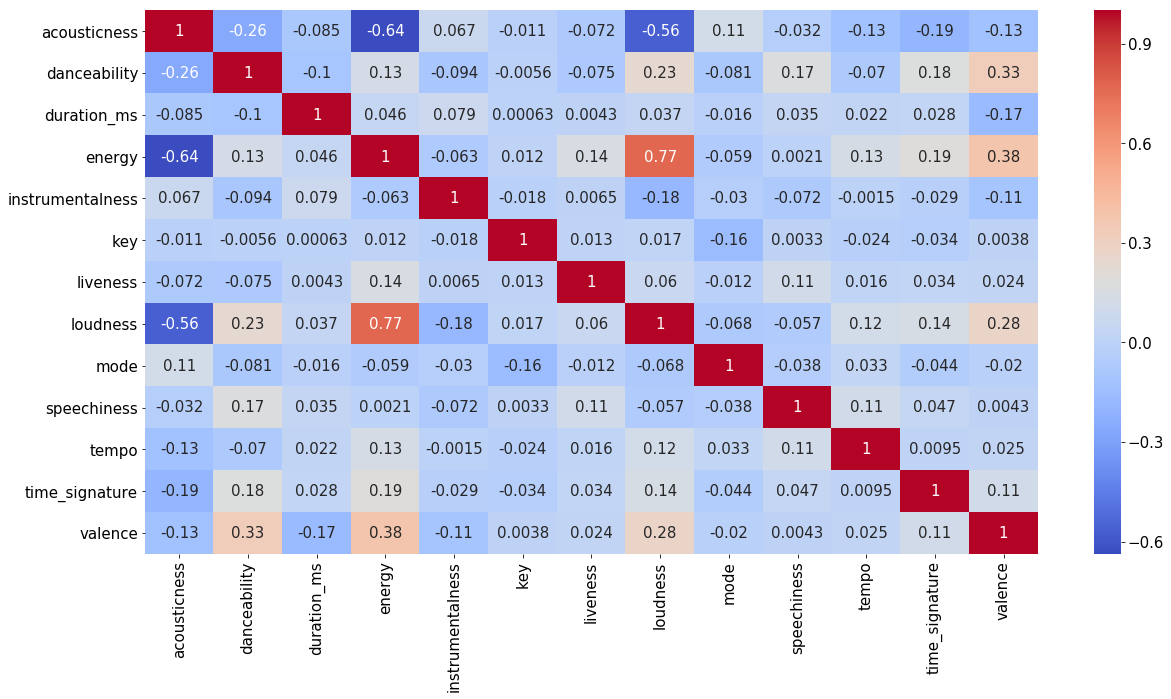

In [7]:
# HeatMap illustrating the correlation among attributes
attr = Data_df.drop(['Total','T10','Days','Pk'], axis=1)
plt.figure(figsize = (20,10))
sns.heatmap(attr.corr(), cmap="coolwarm", annot=True)
plt.show()

The more correlated two music attributes are, the darker the cell is going to be. The more positive a correlation is, the warmer the color of the cell will be. We want to investigate how Spotify API define each music attributes and determine values for each song by looking at how their attributes correlated. We found strong positive correlation between energy and loudness, and strong negative correlation between energy and acousticness, loudness and acousticness. We conclude that the Spotify API’s calculating method for energy, loudness, and acousticness of one song depend on each other.

### Ranking vs Total Streams

In [8]:
y = np.log10(Data_df['Total'])
x = Data_df.index
plt.figure(figsize=(15, 10), dpi=80)
plt.ylabel("Total Streams",)
plt.xlabel("Position")
plt.title("Position vs Total Streams")
plt.scatter(x,y)
ranking = plt.gcf()
#calculating correlation
totalcor = np.corrcoef(x,y)[0,1]

CORRELATION:  -0.994843677808


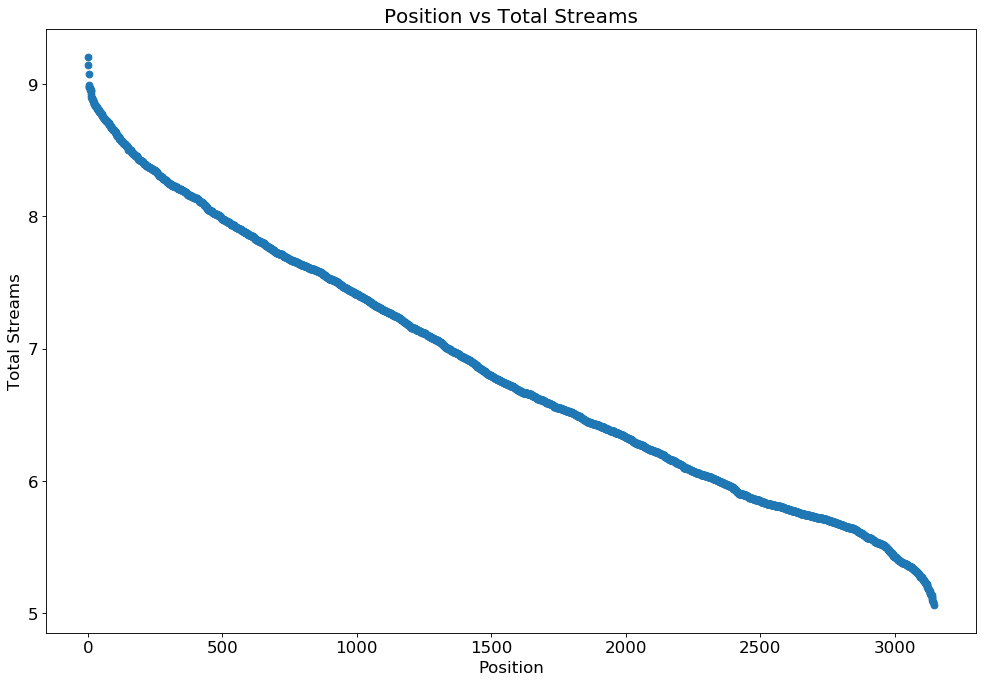

In [9]:
print("CORRELATION: ", totalcor)
ranking

This graph shows that songs’ total streams and their rankings are strongly negatively correlated. We first log transformed the total streams to reduce the skew and found a linear relationship between log(total streams) and its position on the chart. This graph matched with our belief on higher total streams one have result to higher position on the Spotify Chart. We can use this model to predict how many streams one music need to hit in order to get itself into a certain position on the chart.

### OLS for Total streams and Position (Ranking)

In [21]:
outcome, predictors = patsy.dmatrices ('Total ~ Data_df.index', Data_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

In [22]:
print(res.summary())
print("\nCORRELATION:", totalcor)

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     1847.
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          8.27e-318
Time:                        09:34:29   Log-Likelihood:                -62542.
No. Observations:                3144   AIC:                         1.251e+05
Df Residuals:                    3142   BIC:                         1.251e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.979e+08   3.76e+06     52.607

- This OLS Regression Results suggests the model of predicting the total streams for certain ranking as y = exp ( -8.906e+04 x + 1.979e+08). 
- The t-test suggests that there is a 95% confidence intervals for the hypothesis (meaning we predict at a 95% percent confidence that the value of intercept coefficient is between 1.91e+08 to 2.05e+08, and the slope coefficient is between -9.31e+04 and -8.5e+04). 
- The coefficient for the ranking position (Data_df.index) suggests that ranking position is negatively associated with the total streams.
- The p-value being statistically significant (less than 0.05) suggests that we have strong evidence that some correlation exists for ranking and total streams. 

### Acousticness vs Total Streams
 
Visualization of how acousticness affects total streams for all songs that are on the list.

In [42]:
x = Data_df['acousticness']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.ylabel("Total Streams")
plt.xlabel("Acousticness")
plt.title("Acoustiness vs Total Streams")
plt.scatter(x,y)
acousticness = plt.gcf()

#calculating correlation
acoustcor = np.corrcoef(x,y)[0,1]

In [43]:
print("CORRELATION: ", acoustcor)

CORRELATION:  -0.118067031927


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: -0.108408291493


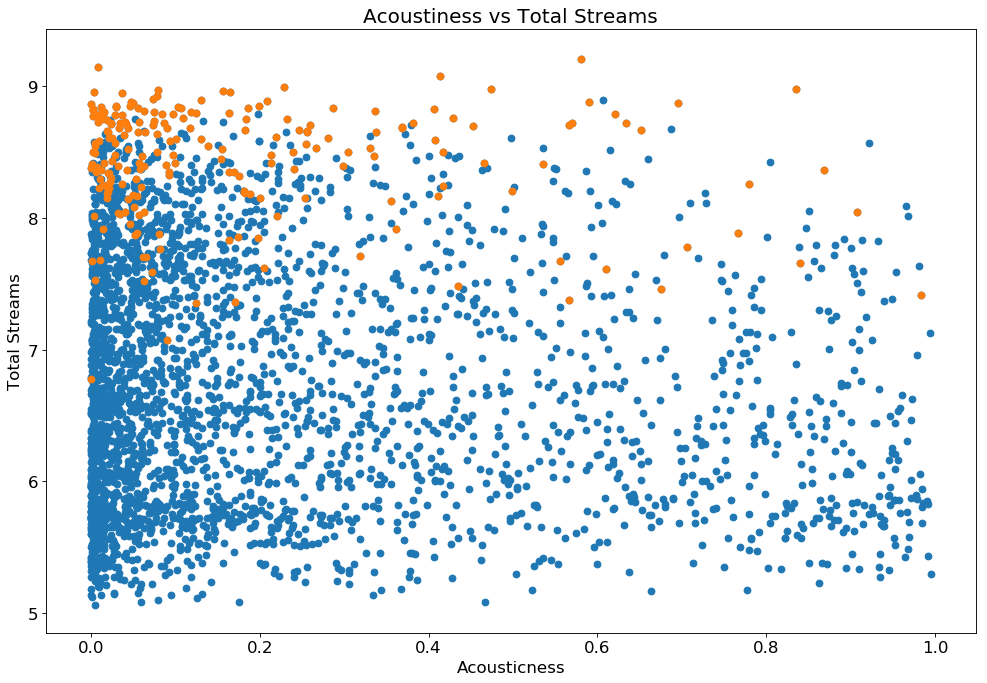

In [44]:
# Highlight the ones that have been in the top 10 list of the chart.
df_Pk1 = Data_df[Data_df['Pk'] < 11 ]

x = df_Pk1['acousticness']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Acousticness")
plt.title("Acoustiness vs Total Streams")
plt.scatter(x,y)
acousticness = plt.gcf()

#calculating acousticness
acoustcor1 = np.corrcoef(x,y)[0,1]

print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", acoustcor1)
acousticness

This graph shows the total streams of each song with a certain acousticness value. Tracks with higher acousticness will have a value closer to 1.0. We highlighted the top 100 tracks in orange to compare the highest ranking songs with the rest of the tracks. Though the correlation between acousticness and total streams is not strong, the skew in this graph shows that most songs on the chart have low acousticness value.


#### Distribution plot for Acousticness

Mean value for acousticness: 0.21755669945928757


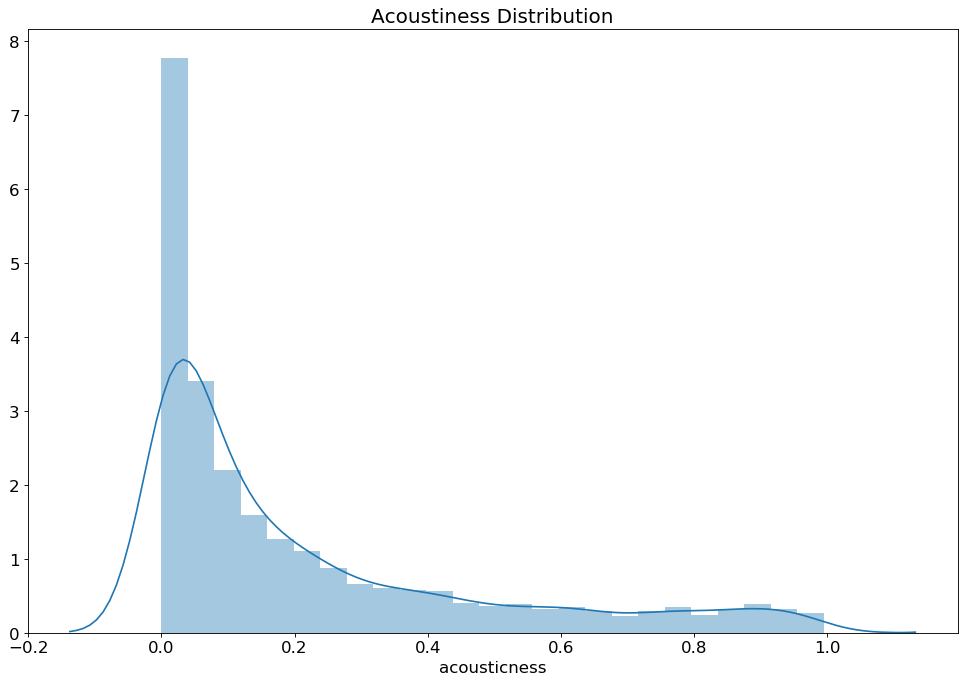

In [17]:
print("Mean value for acousticness:", Data_df['acousticness'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['acousticness'])
plt.title("Acoustiness Distribution")
plt.show()

This distribution graph shows that the density of the distribution is highest at an acousticness value of around 0.2 to 0.3. The mean value for energy is 0.22, meaning that users show more favoritism to songs with low acoustic features. We conclude that most songs that make it to the top charts tend to have lower acoustic features. 

### Danceability vs Total Streams

Visualization of how danceability affects total streams for all songs on the list.

In [18]:
x = Data_df['danceability']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.ylabel("Total Streams")
plt.xlabel("Danceability")
plt.title("Danceability vs Total Streams")
plt.scatter(x,y)
danceability = plt.gcf()

#calculating correlation
dancecor = np.corrcoef(x,y)[0,1]

In [19]:
print("CORRELATION: ", dancecor)

CORRELATION:  0.210059644348


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: 0.12829875347


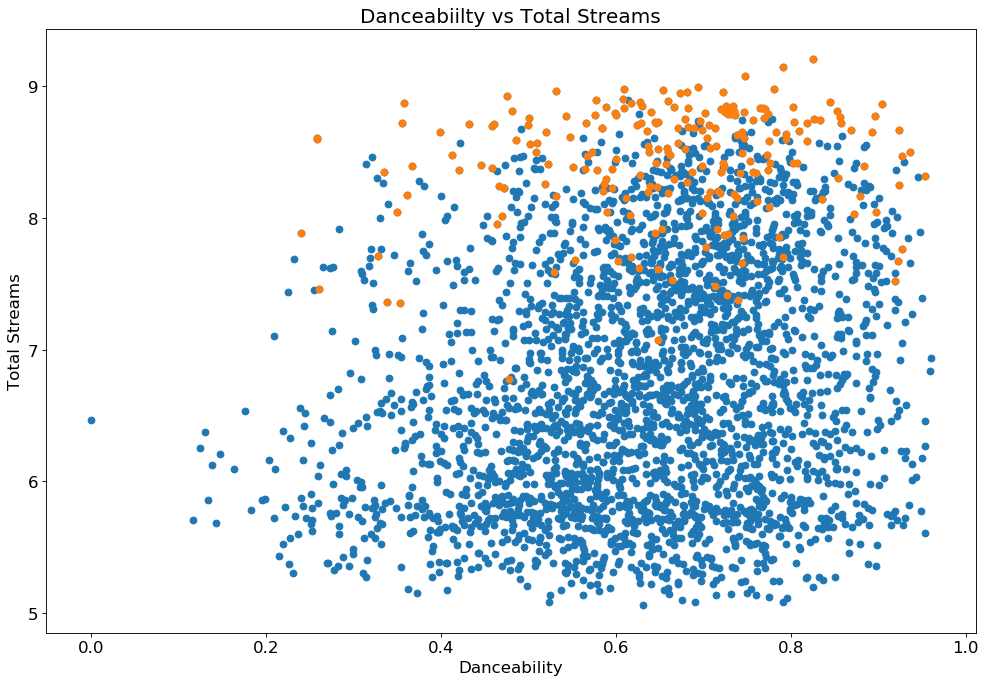

In [20]:
# Highlight the ones that have been in the top 10 of the chart
x = df_Pk1['danceability']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Danceability")
plt.title("Danceabiilty vs Total Streams")
plt.scatter(x,y)
danceabiilty = plt.gcf()

#calculating acousticness
dancecor1 = np.corrcoef(x,y)[0,1]

print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", dancecor1)
danceability

This graph shows the total streams of each song with a certain danceability value. Tracks with higher danceability will have a value closer to 1.0. We highlighted the top 100 tracks in orange to compare the highest ranking songs with the rest of the tracks. Though the correlation between danceability and total streams is not strong, the skew of the scatter points in this graph shows that most songs on the chart have high danceability value.


#### Distribution plot for Danceability

Mean value for danceability: 0.6343393765903301


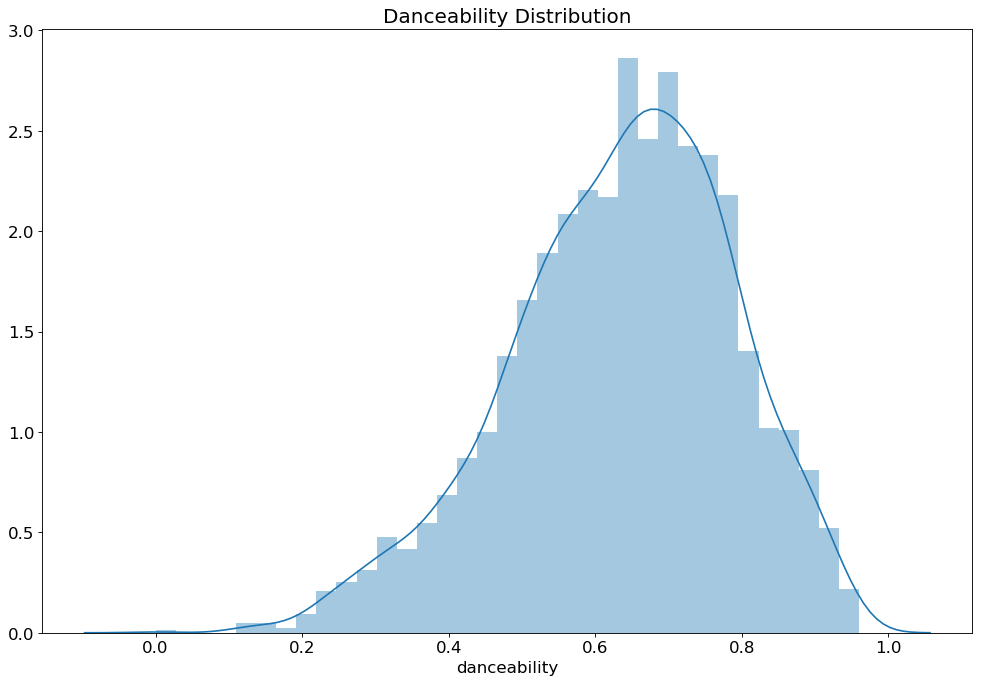

In [32]:
print("Mean value for danceability:", Data_df['danceability'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['danceability'])
plt.title("Danceability Distribution")
plt.show()

This distribution graph shows that the density of the distribution is highest at an danceability value of around 0.6 to 0.7. The mean value for energy is 0.63, meaning that users like songs that are more danceable. We conclude that most songs that make it to the top charts tend to have more danceable features. 

### Energy vs Total Streams

Visualization of how energy affects total streams for all songs on the list.

In [21]:
x = Data_df['energy']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.ylabel("Total Streams")
plt.xlabel("Energy")
plt.title("Energy vs Total Streams")
plt.scatter(x,y)
energy = plt.gcf()

#calculating correlation
energycor = np.corrcoef(x,y)[0,1]

In [22]:
print("CORRELATION: ", energycor)

CORRELATION:  0.0647662505139


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: 0.122568958193


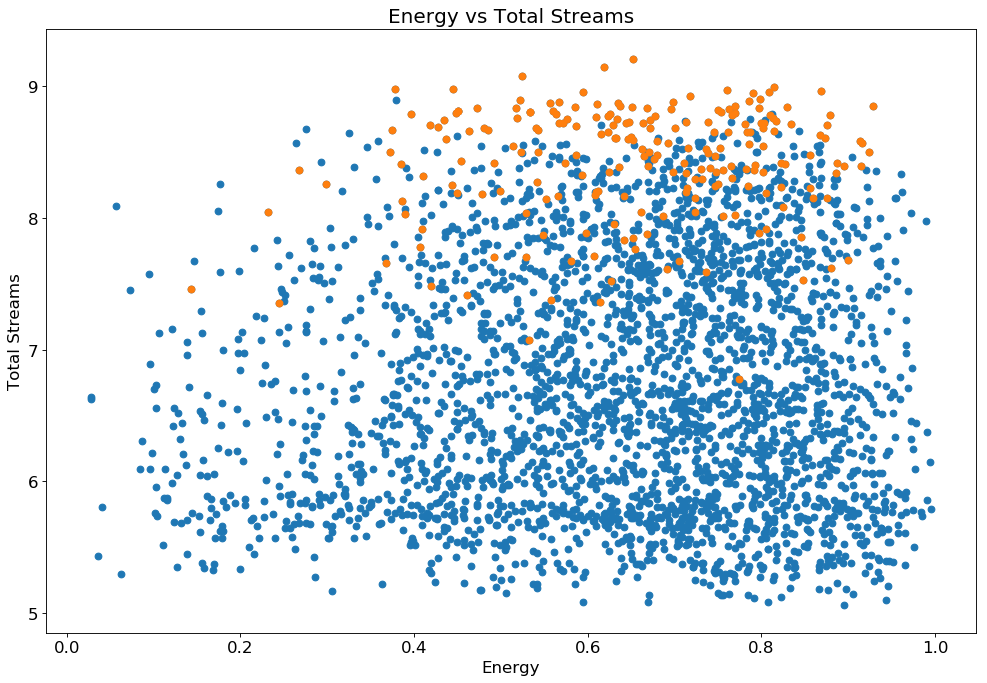

In [23]:
# Highlight the ones that have been in the top 10 list of the chart
x = df_Pk1['energy']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Energy")
plt.title("Energy vs Total Streams")
plt.scatter(x,y)
energy = plt.gcf()

#calculating acousticness
energycor1 = np.corrcoef(x,y)[0,1]

#print correlation for song that have been in top 10
print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", energycor1)
energy

This graph shows the total streams of each song with a certain energy value. Tracks with higher energy will have a value closer to 1.0. We highlighted the top 100 tracks in orange to compare the highest ranking songs with the rest of the tracks. There is a slight correlation between energy and total streams. The higher energy tracks tend to have more total streams.

#### Distribution plot for Energy

Mean value for energy: 0.6415937977099249


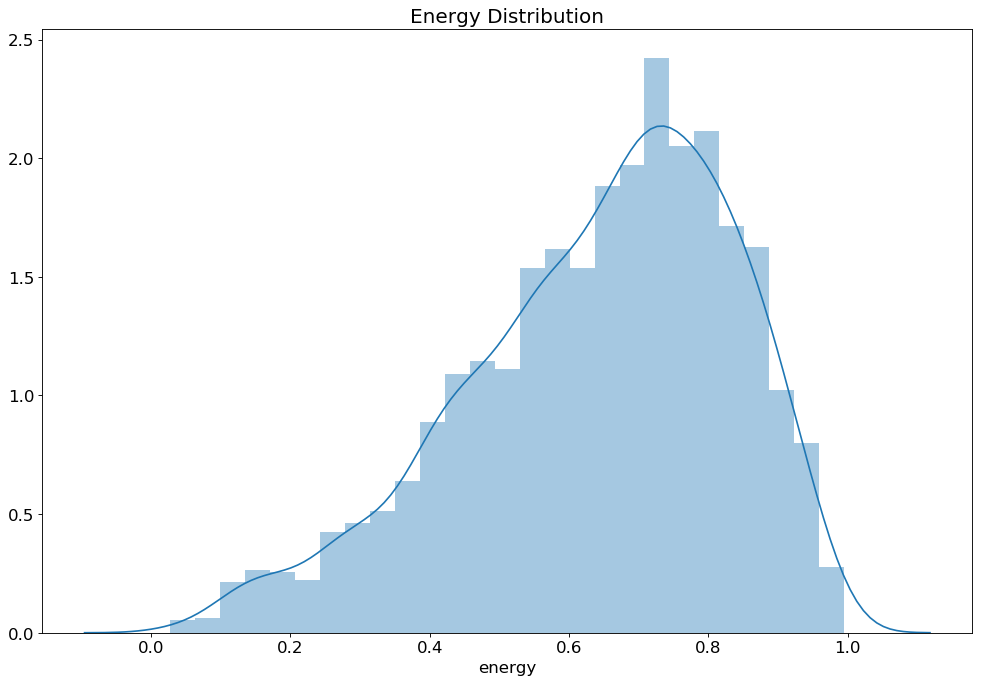

In [37]:
print("Mean value for energy:", Data_df['energy'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['energy'])
plt.title("Energy Distribution")
plt.show()

This distribution graph shows that the density of the distribution is highest at an energy value of around 0.6 - 0.7. The mean value for energy is 0.64, meaning that most songs that make it to the top charts tend to have higher energy.

### Instrumentalness vs Total Streams

Visualization of how instrumentalness affects total streams for all songs on the list.

In [24]:
x = Data_df['instrumentalness']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.ylabel("Total Streams")
plt.xlabel("Instrumentalness")
plt.title("Instrumentalness vs Total Streams")
plt.scatter(x,y)
instrumentalness = plt.gcf()

#calculating correlation
instrumentcor = np.corrcoef(x,y)[0,1]

In [25]:
print("CORRELATION: ", instrumentcor)

CORRELATION:  -0.114765160776


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: -0.279130579718


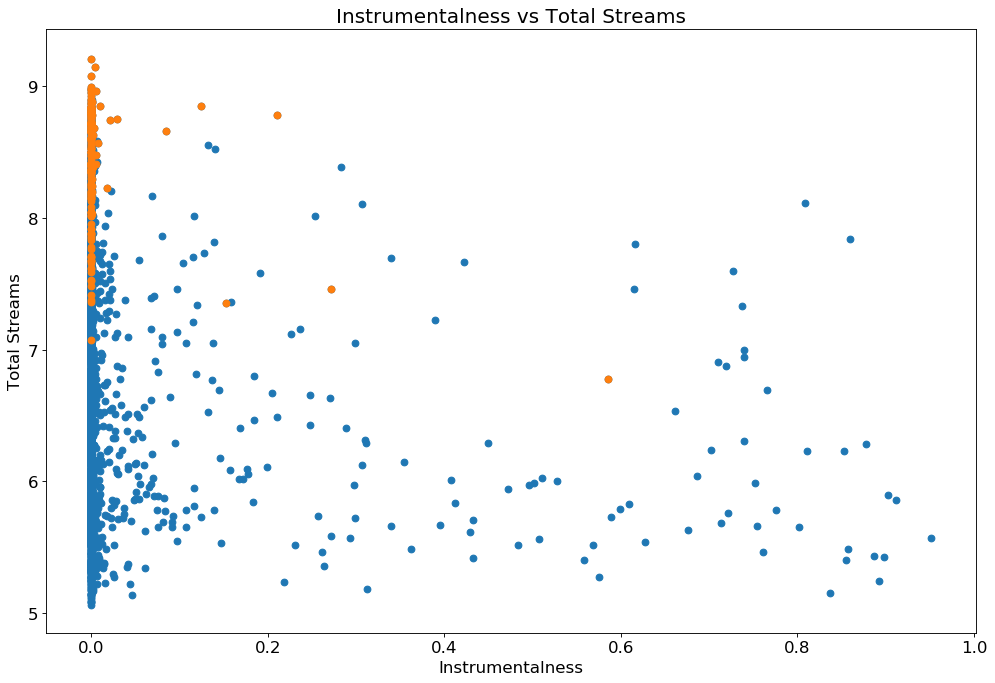

In [26]:
# Highlight the ones that have been in the top 10 list of the chart
x = df_Pk1['instrumentalness']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Instrumentalness")
plt.title("Instrumentalness vs Total Streams")
plt.scatter(x,y)
instrumentalness = plt.gcf()

#calculating acousticness
instrumentcor1 = np.corrcoef(x,y)[0,1]

print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", instrumentcor1)
instrumentalness

This graph shows that most top tracks have an instrumentalness value close to 0. This means that top tracks usually have a lot of vocals.

#### Distribution plot for Instrumentalness

Mean value for instrumentalness: 0.0190415600508906


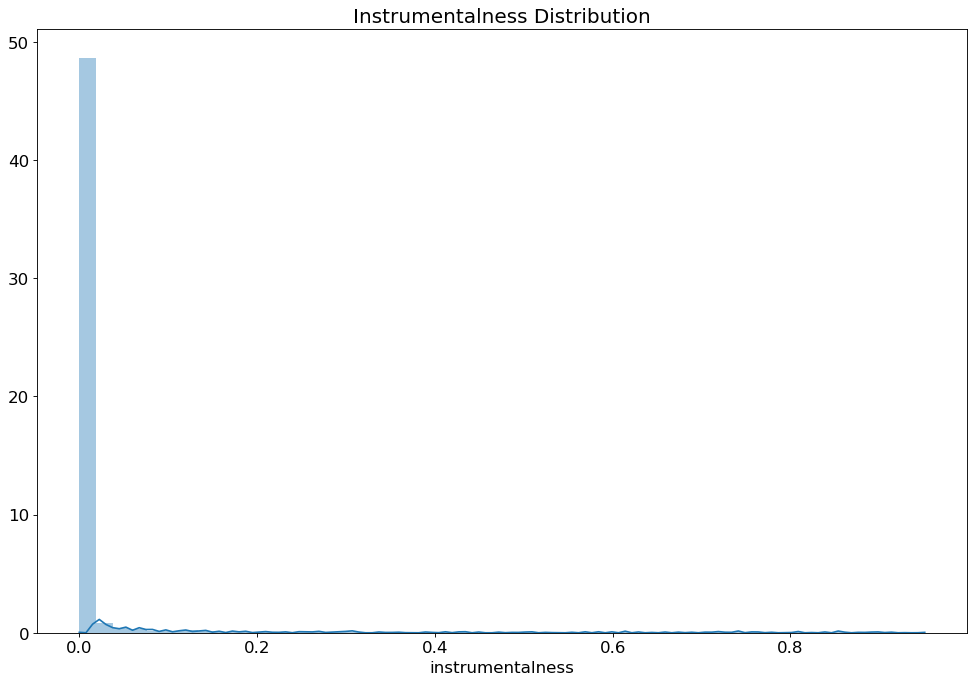

In [42]:
print("Mean value for instrumentalness:", Data_df['instrumentalness'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['instrumentalness'])
plt.title("Instrumentalness Distribution")
plt.show()

This shows that there is a large amount of tracks with an instrumentalness close to 0. The mean value of instrumentalness is 0.019, so most songs on the charts have a lot of vocals.

### Key vs Total Streams

Visualization of how key affects total streams for all songs on the list.

In [43]:
#accumulating the number of total streams per key
df_key0 = Data_df[Data_df['key']==0]
key0 = df_key0['Total'].sum()

df_key1 = Data_df[Data_df['key']==1]
key1 = df_key1['Total'].sum()

df_key2 = Data_df[Data_df['key']==2]
key2 = df_key2['Total'].sum()

df_key3 = Data_df[Data_df['key']==3]
key3 = df_key3['Total'].sum()

df_key4 = Data_df[Data_df['key']==4]
key4 = df_key4['Total'].sum()

df_key5 = Data_df[Data_df['key']==5]
key5 = df_key5['Total'].sum()

df_key6 = Data_df[Data_df['key']==6]
key6 = df_key6['Total'].sum()

df_key7 = Data_df[Data_df['key']==7]
key7 = df_key7['Total'].sum()

df_key8 = Data_df[Data_df['key']==8]
key8 = df_key8['Total'].sum()

df_key9 = Data_df[Data_df['key']==9]
key9 = df_key9['Total'].sum()

df_key10 = Data_df[Data_df['key']==10]
key10 = df_key10['Total'].sum()

df_key11 = Data_df[Data_df['key']==11]
key11 = df_key11['Total'].sum()

df_key11 = Data_df[Data_df['key']==11]
key11 = df_key11['Total'].sum()


#graph
keys = [key1, key2, key3, key4, key5, key6, key7, key8, key9, key10, key11]
N = len(keys)
x = range(N)
width = 1/1.5
plt.figure(figsize=(15, 10), dpi=80)
plt.bar(x, keys, width)
plt.ylabel("Total Streams")
plt.xlabel("Key")
plt.title("Key vs Total Streams")


key = plt.gcf()

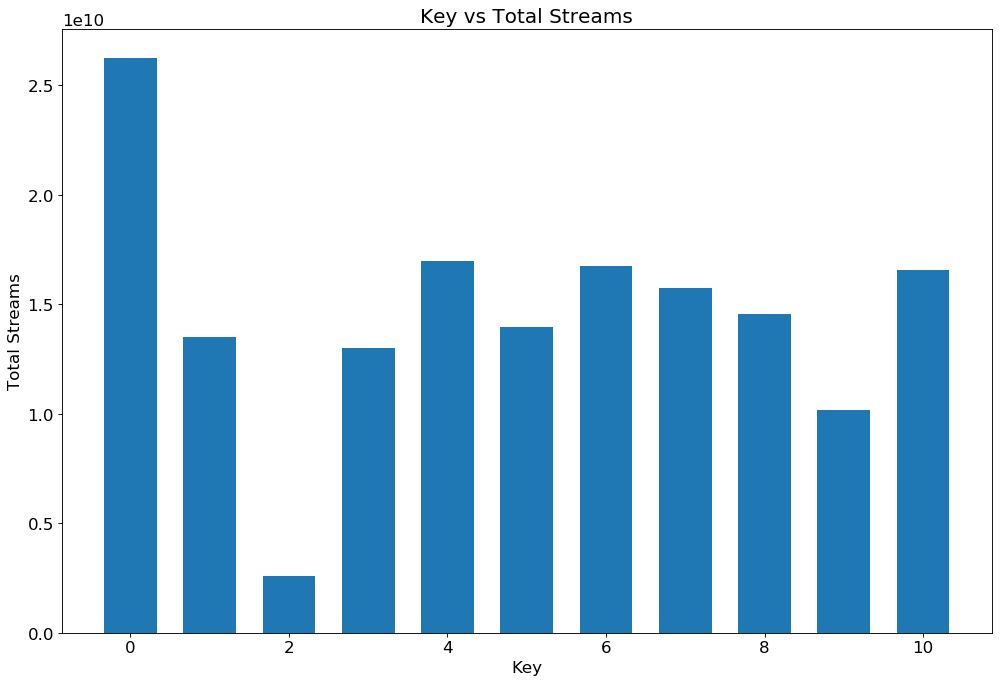

In [44]:
key

This graph shows that the majority of the tracks have a key of C. This also shows that very few tracks use the key of D.

### Liveness vs Total Streams

Visualization of how liveness affects total streams for all songs on the list.

In [27]:
x = Data_df['liveness']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel("liveness")
plt.ylabel("Total Streams")
plt.title("Liveness vs Total Streams")
plt.scatter(x,y)
liveness = plt.gcf()

#CALCULATING CORRELATION
livecor = np.corrcoef(x,y)[0,1]

In [28]:
print("CORRELATION: ", livecor)

CORRELATION:  -0.0422913327115


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: -0.16310702154


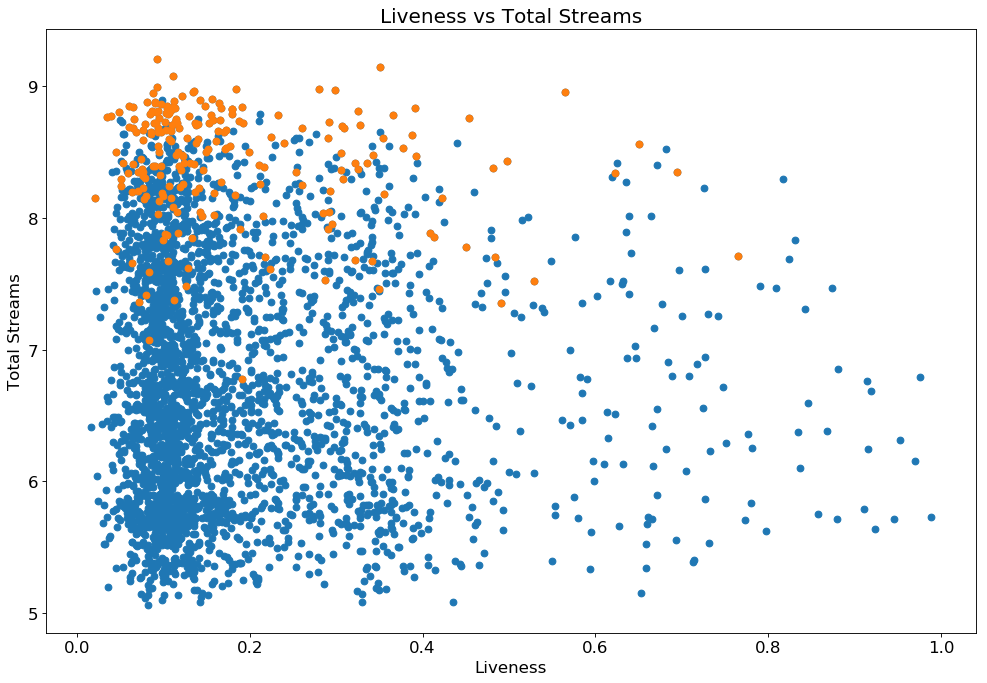

In [29]:
# Highlight the ones that have been in the top 10 list of the chart
x = df_Pk1['liveness']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Liveness")
plt.title("Liveness vs Total Streams")
plt.scatter(x,y)
liveness = plt.gcf()

#calculating acousticness
livecor1 = np.corrcoef(x,y)[0,1]

print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", livecor1)
liveness

This graph shows that they majority of the tracks have a liveness rating closer to 0. Most tracks do not have a strong likelihood that the track is live.

#### Distribution plot for Liveness

Mean value for liveness: 0.18534573791348605


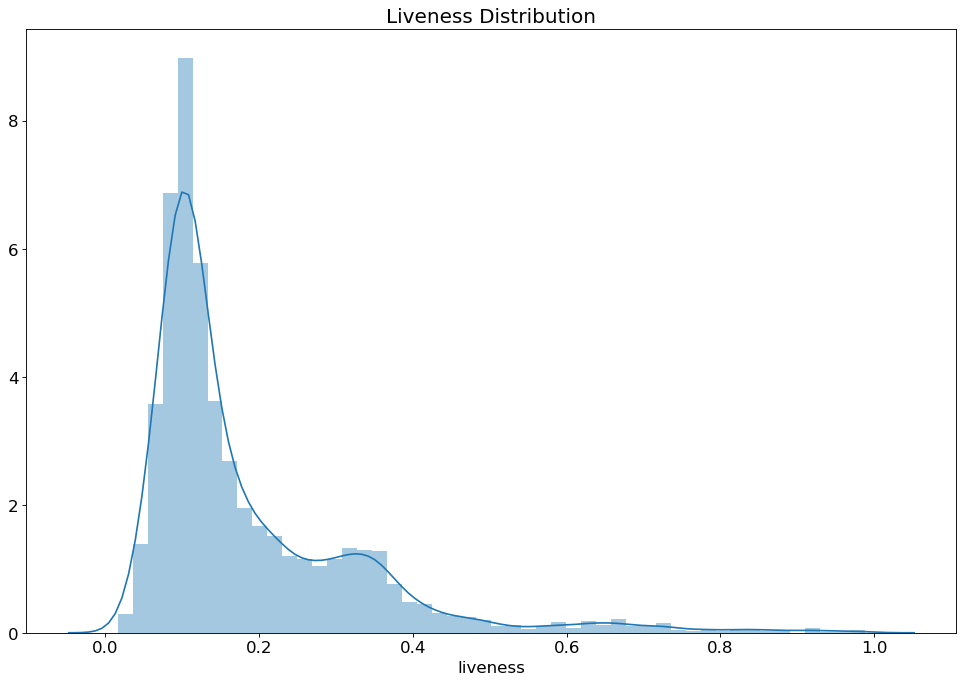

In [49]:
print("Mean value for liveness:", Data_df['liveness'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['liveness'])
plt.title("Liveness Distribution")
plt.show()

The distribution graphs shows that the average liveness rating is around 0.185. It shows a positively skewed graph which illustrates that very few top chart songs have a live audience. 

### Loudness vs Total Streams

Visualization of how loudness affects total streams for all songs on the list.

In [30]:
x = Data_df['loudness']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel("loudness")
plt.ylabel("Total Streams")
plt.title("Loudeness vs Total Streams")
plt.scatter(x,y)
loudness = plt.gcf()

#CALCULATING CORRELATION
loudcor = np.corrcoef(x,y)[0,1]

In [31]:
print("CORRELATION: ", loudcor)

CORRELATION:  0.166771662843


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: 0.309935328787


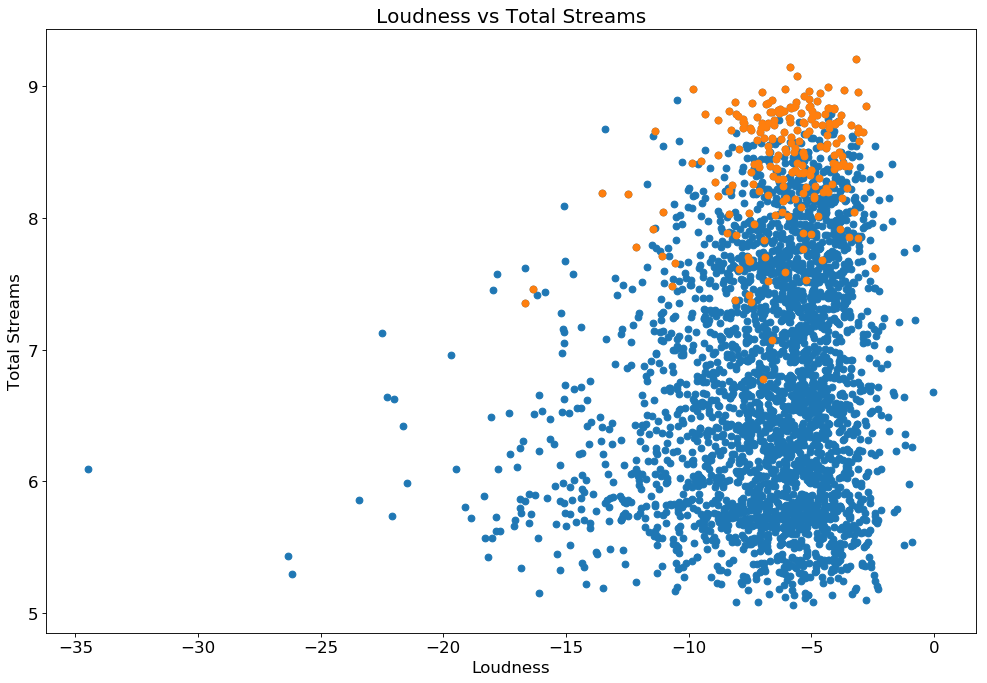

In [32]:
# Highlight the ones that have been in the top 10 list of the chart
x = df_Pk1['loudness']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Loudness")
plt.title("Loudness vs Total Streams")
plt.scatter(x,y)
loudness = plt.gcf()

#calculating acousticness
loudcor1 = np.corrcoef(x,y)[0,1]

print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", loudcor1)
loudness

In this graph, we highlighted the top 100 tracks in orange to compare the loudness of those to the rest of the tracks. We conclude that the top tracks are around -2.5 to 10 dB.

#### Distribution plot for Loudness

Mean value for loudness: -6.699220419847344


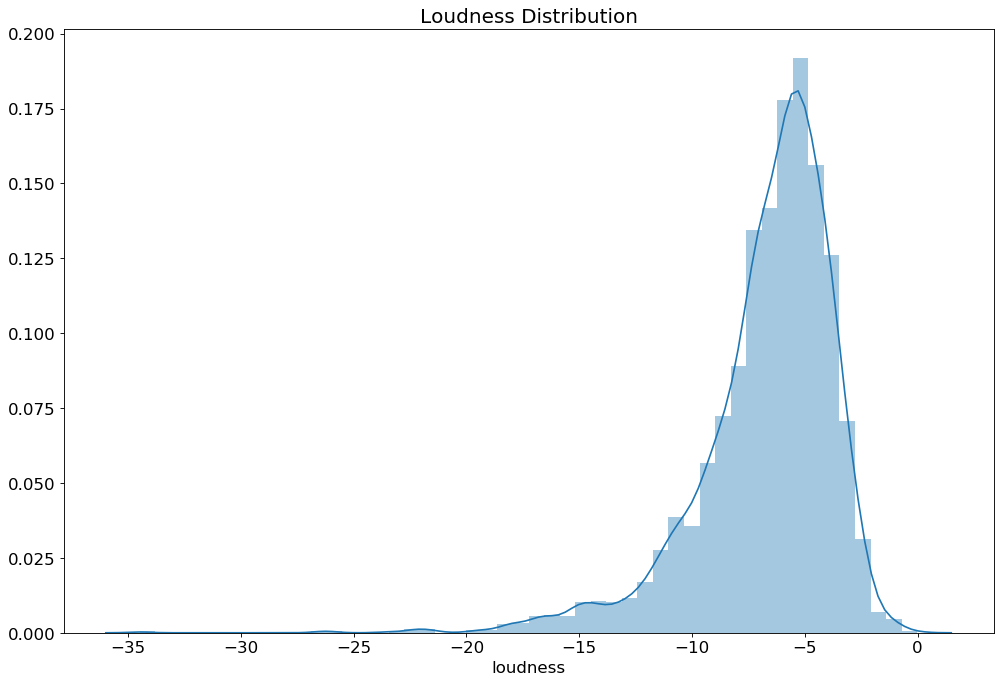

In [54]:
print("Mean value for loudness:", Data_df['loudness'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['loudness'])
plt.title("Loudness Distribution")
plt.show()

This graph is negatively skewed and show that tracks usually have a loudness of -6 dB.

### Speechiness vs Total Streams

Visualization of how speechiness affects total streams for all songs on the list.

In [33]:
x = Data_df['speechiness']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel("Speechiness")
plt.ylabel("Total Streams")
plt.title("Speechiness vs Total Streams")
plt.scatter(x,y)
speechiness = plt.gcf()

#CALCULATING CORRELATION
speechcor = np.corrcoef(x,y)[0,1]

In [34]:
print("CORRELATION: ", speechcor)

CORRELATION:  0.0138286627563


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: -0.126299442286


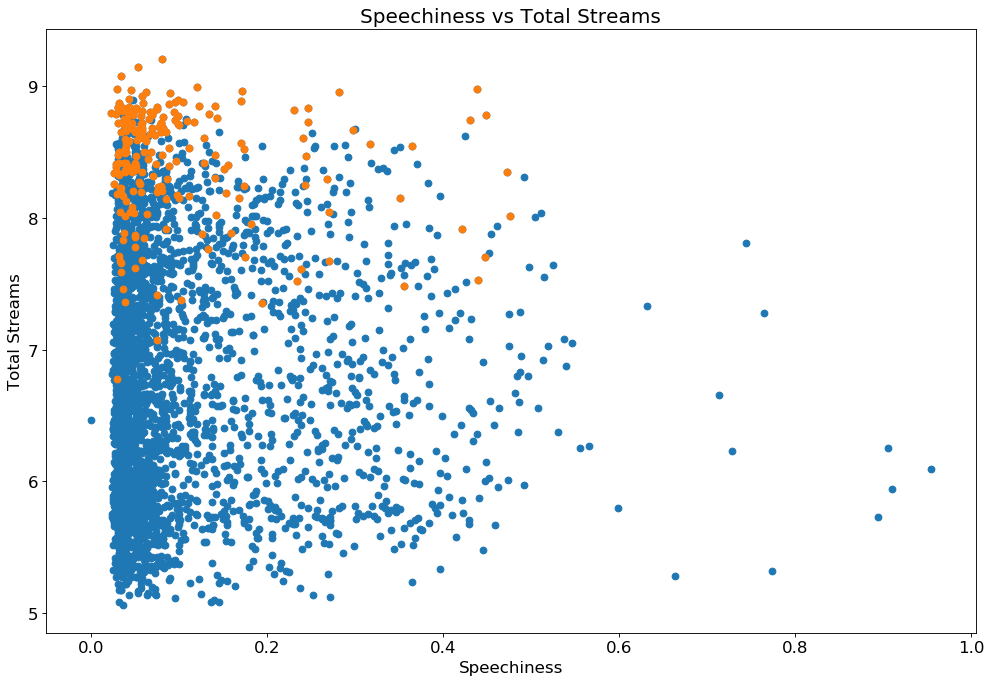

In [35]:
# Highlight the ones that have been in the top 10 list of the chart
x = df_Pk1['speechiness']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Speechiness")
plt.title("Speechiness vs Total Streams")
plt.scatter(x,y)
speechiness = plt.gcf()

#calculating acousticness
speechcor1 = np.corrcoef(x,y)[0,1]

print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", speechcor1)
speechiness

#### Distribution plot for Speechiness

Mean value for speechiness: 0.10643975826972006


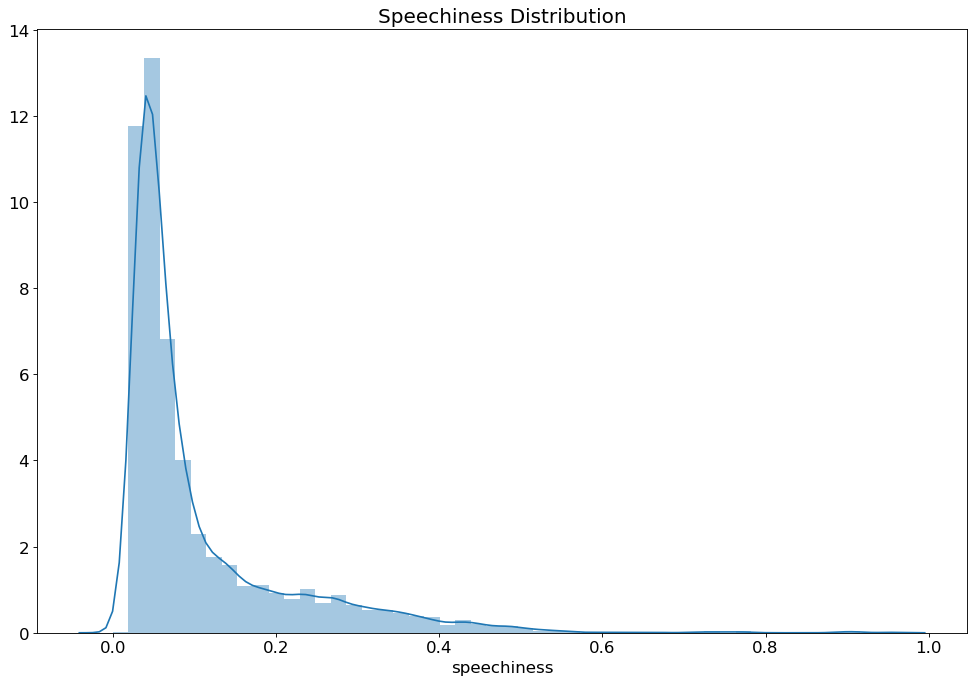

In [59]:
print("Mean value for speechiness:", Data_df['speechiness'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['speechiness'])
plt.title("Speechiness Distribution")
plt.show()

### Tempo vs Total Streams

Visualization of how tempo affects total streams for all songs on the list.

In [36]:
x = Data_df['tempo']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel("Tempo")
plt.ylabel("Total Streams")
plt.title("Tempo vs Total Streams")
plt.scatter(x,y)
tempo = plt.gcf()

#CALCULATING CORRELATION
tempocor = np.corrcoef(x,y)[0,1]

In [37]:
print("CORRELATION:", tempocor)

CORRELATION: -0.0188053852214


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: -0.0448259472487


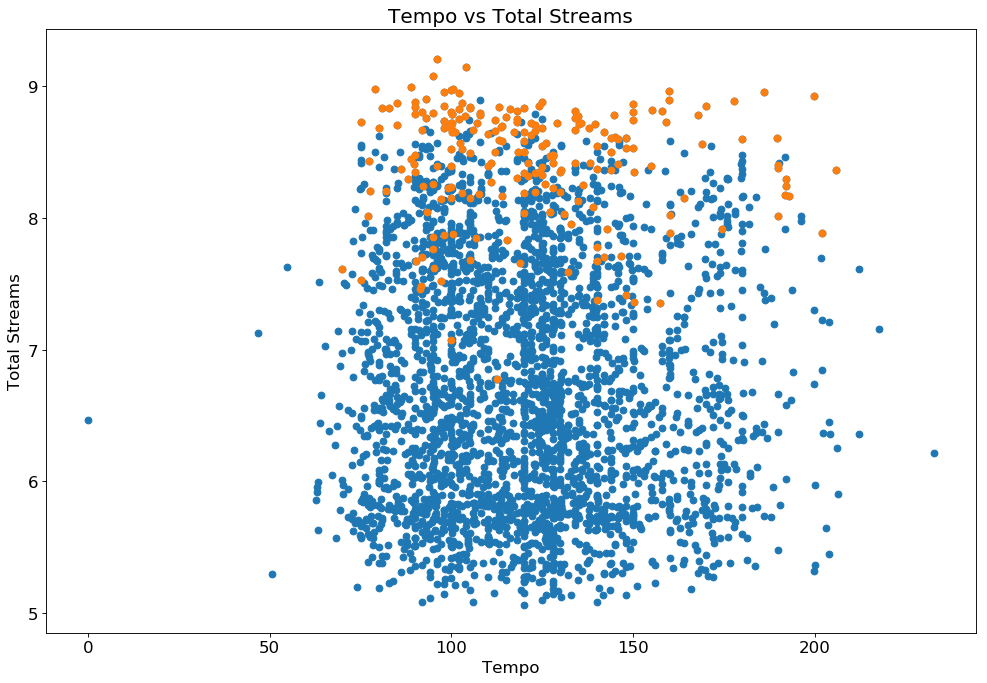

In [38]:
# Highlight the ones that have been in the top 10 list of the chart
x = df_Pk1['tempo']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Tempo")
plt.title("Tempo vs Total Streams")
plt.scatter(x,y)
tempo = plt.gcf()

#calculating acousticness
tempocor1 = np.corrcoef(x,y)[0,1]

print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", tempocor1)
tempo

In this graph, we see that the majority of the tracks have a tempo of around 75 bpm to 150 bpm. It is rare or nearly impossible to find top tracks with slower than 50 bpm or faster than 200 bpm.


#### Distribution plot for Tempo

Mean value for tempo: 120.55089662849876


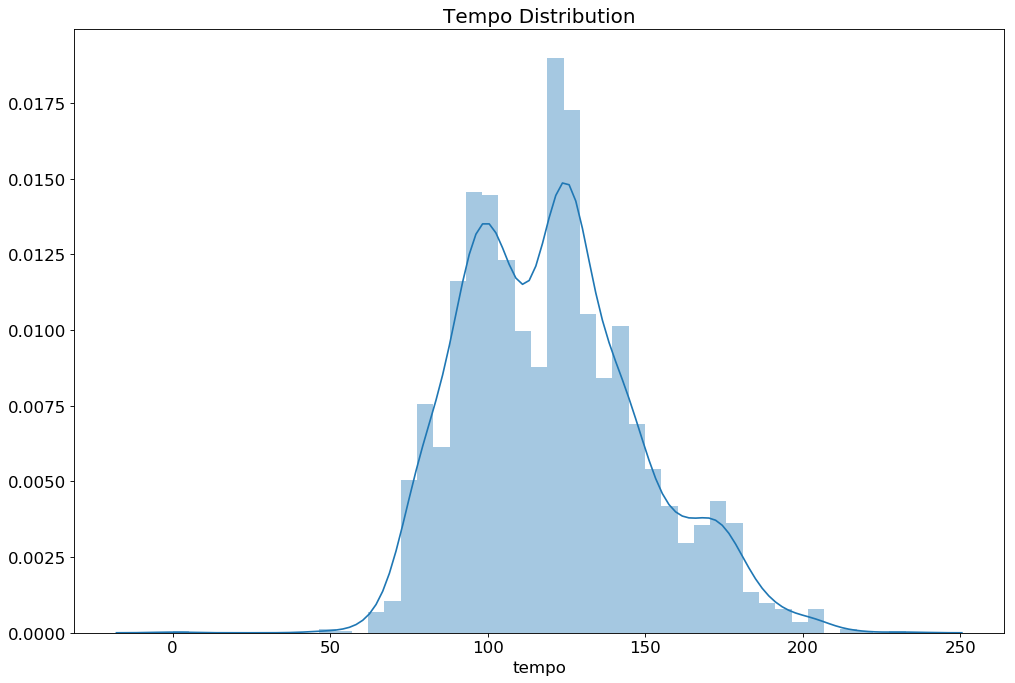

In [64]:
print("Mean value for tempo:", Data_df['tempo'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['tempo'])
plt.title("Tempo Distribution")
plt.show()

In the tempo graph, we see that there is a distribution with 2 peaks at 100 bpm and 125 bpm, meaning the peaks are close together, and show a subtly positive skew.


### Time Signature vs Total Streams

Visualization of how signature affects total streams for all songs on the list.

In [46]:
#accumulating total streams for each time signature
df_time0 = Data_df[Data_df['time_signature']==0]
time0 = df_time0['Total'].sum()

df_time1 = Data_df[Data_df['time_signature']==1]
time1 = df_time1['Total'].sum()

df_time2 = Data_df[Data_df['time_signature']==2]
time2 = df_time2['Total'].sum()

df_time3 = Data_df[Data_df['time_signature']==3]
time3 = df_time3['Total'].sum()

df_time4 = Data_df[Data_df['time_signature']==4]
time4 = df_time4['Total'].sum()

df_time5 = Data_df[Data_df['time_signature']==5]
time5 = df_time5['Total'].sum()


#graph
times = [time0, time1, time2, time3, time4, time5]
label = [0,1,2,3,4,5]
N= len(times)
x= range(N)
width = 1/1.5
plt.figure(figsize=(10,15))
plt.bar(x, times, width, color='blue')
plt.title("Time Signature vs Total Streams")
plt.xlabel("Time Signature")
plt.ylabel("Total Streams")

time_signature = plt.gcf()

Time Signature 0: 2907539 number of streams
Time Signature 1: 78276322 number of streams
Time Signature 2: 0 number of streams
Time Signature 3: 3620104320 number of streams
Time Signature 4: 176063169513 number of streams
Time Signature 5: 2254883802 number of streams


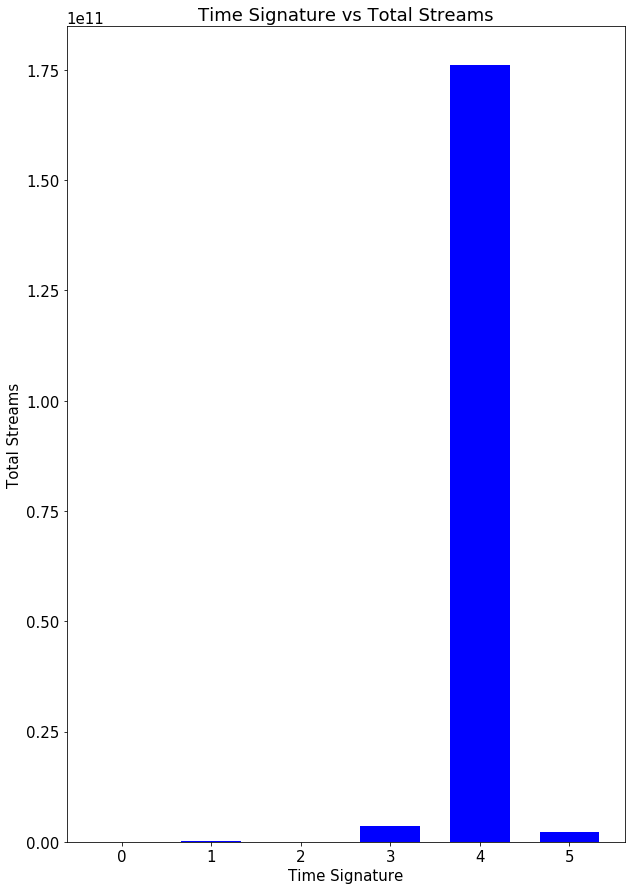

In [48]:
i=0
for sig in times:
    print("Time Signature "+ str(i) + ": "+ str(sig), "number of streams")
    i+=1

time_signature

For the time signature graph, it is clear that the time signature of 4/4 is overwhelmingly the most popular choice. There is a minuscule number of tracks in 3 or 5.


### Valence vs Total Streams

Visualization of how valence affects total streams for all songs on the list.

In [39]:
x = Data_df['valence']
y = np.log10(Data_df['Total'])
plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel("Valence")
plt.ylabel("Total Streams")
plt.title("Valence vs Total Streams")
plt.scatter(x,y)

valence = plt.gcf()

#CALCULATING CORRELATION
valencor = np.corrcoef(x,y)[0,1]

In [40]:
print("CORRELATION:", valencor)

CORRELATION: 0.0591137082325


CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10: 0.0668550099432


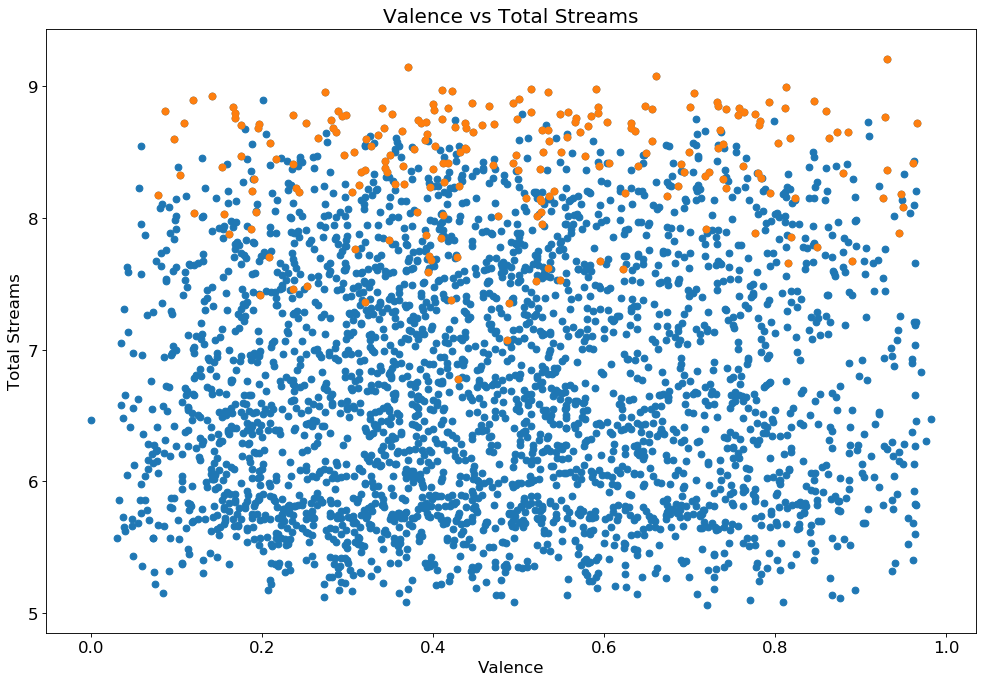

In [41]:
# Highlight the ones that have been in the top 10 list of the chart
x = df_Pk1['valence']
y = np.log10(df_Pk1['Total'])

plt.ylabel("Total Streams")
plt.xlabel("Valence")
plt.title("Valence vs Total Streams")
plt.scatter(x,y)
valence = plt.gcf()

#calculating acousticness
valencor1 = np.corrcoef(x,y)[0,1]

print("CORRELATION FOR SONGS THAT HAVE BEEN IN TOP 10:", valencor1)
valence

We see in the valence scatter plot, regardless of whether it is the top 100 songs or the whole dataset, there is no correlation. There are tracks of valence all the way from 0.0 to 1.0 placed quite evenly across the graph.


#### Distribution plot for Valence

Mean value for valence: 0.4697865139949106


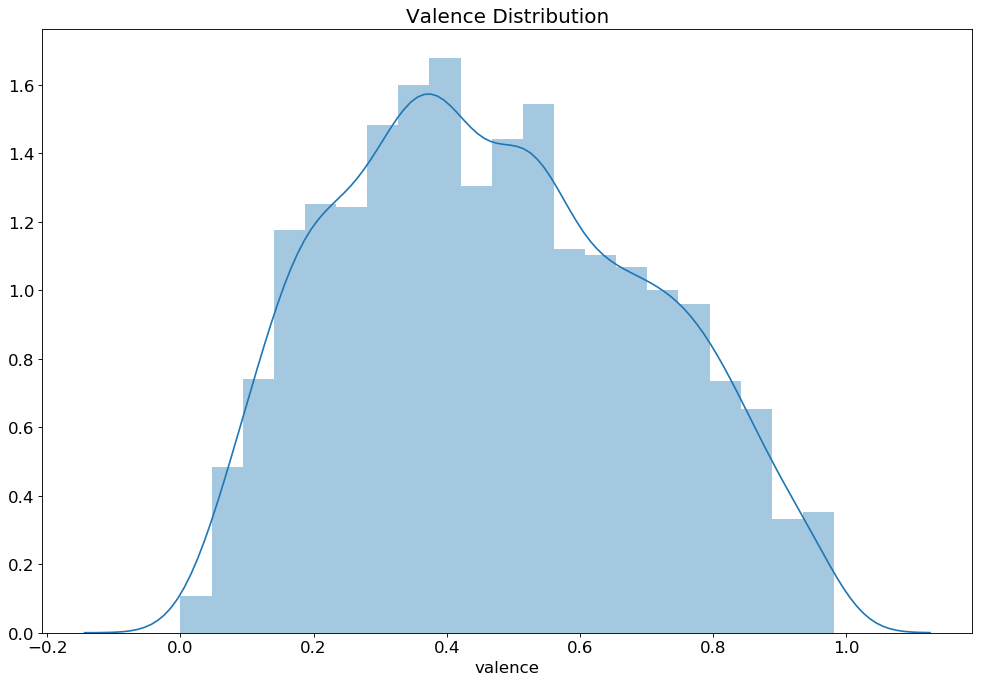

In [71]:
print("Mean value for valence:", Data_df['valence'].mean())
plt.figure(figsize=(15, 10), dpi=80)
sns.distplot(Data_df['valence'])
plt.title("Valence Distribution")
plt.show()

The valence distribution shows a little bit of a positive skew, centered around .4.


### Acousticness vs Energy

In [6]:
x = Data_df['acousticness']
y = Data_df['energy']
plt.figure(figsize=(15, 10), dpi=80)
plt.xlabel("Acousticness")
plt.ylabel("Energy")
plt.title("Acousticness vs Energy")
plt.scatter(x,y)
acoustic_energy = plt.gcf()

#CALCULATING CORRELATION
acoustic_energy_cor = np.corrcoef(x,y)[0,1]

CORRELATION:  -0.636854981212


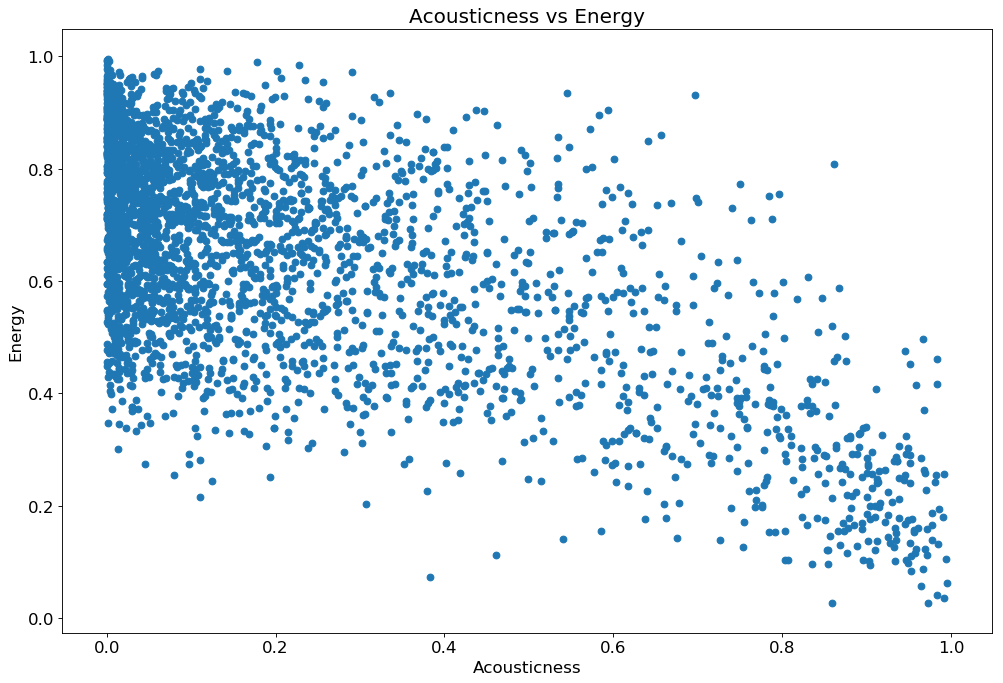

In [7]:
print("CORRELATION: ", acoustic_energy_cor)
acoustic_energy

We see that there is a negative correlation between acoustic ness and energy, with most tracks having low acousticness and high energy. 

# Data Analysis

In order to visualize the data, we realized that we needed to use a variety of graphing methods to best represent it, including scatter graphs, bar charts, and distribution skews. We see a strong correlation between acousticness and total streams, suggesting that top songs will have lower acoustic features.  We also see a moderate correlation between danceability and total streams, implying that top songs will have higher danceability, and the same goes for energy. For instrumentalness we see that nearly all tracks have plenty of vocals. Lastly, it is very unlikely that a top track will be live, and loudness seemed to be clustered at -6 db. 
The top artists are organized via number of streams. Who the top artists are can have an effect on the top songs. The rank of the song depends on the artist, thus showing the bias of whose fans listen on Spotify. The top 3 artists are Drake, Ed Sheeran, and The Chainsmokers. Interestingly, even though Ed Sheeran has the most streamed song, Drake is the top artist.


# Conclusion and Discussion

Our project investigated if there is a correlation between certain audio features and position on top charts based on data from Spotify. We predicted that tracks with higher valence, energy, and danceability will have a higher position on the charts. Using data from data scientist nicknamed Kworb and Spotify’s API, we compiled a listing of the tracks from the top charts with their unique attribute values. It’s important to note that Spotify’s main audience is from the mid-teens to early 30s, so the song plays are going to reflect these specific generations of people more heavily. The attributes we focused on were danceability, valence, tempo, key, instrumentalness, acousticness, energy, time signature, and speechiness. 

We web scraped the chart from Kworb.net and added it to a CSV file. To clean the dataset we compiled song data from 2014/8/10 to 2018/02/26. The song data included artist and song name, the position of the song, days since song release and on top 10 chart, peak position and the total number of streams. We took out two rows (Jenny Duncan and Daniel Mercy) that did not have a track or Spotify link attached so that we could correctly loop through each of the tracks for their attributes. We extracted the song ID from each track link in order to use Spotify’s API to extract all the attributes from each song. 

In order to see how various features affected ranking, we compared the average for each attribute - with its value for some of the top songs. For instance, acousticness on average is about 0.22 but in the case of some of the top songs, it tends to be greater than 0.4. At first, we created scatter plots comparing each attribute with total streams. We realized that some of the results we got from the scatter plots were not significant. We created distribution graphs for each of the attributes and got better results for our data. We analyzed the distribution of the various attributes and found the range in which each attribute correlates to the most streams. We further analyzed the correlation among all attributes using the heatmap from the Seaborn package. We also analyzed the artists with the most streams on Spotify to see if the artist has an effect on the top songs since the top charts are mostly comprised of top artists. Based on this comprehensive analysis we conclude that top ranking songs have higher danceability, energy, acousticness. 

If we were to expand on this project, we would include lyric analysis to better understand the attributes of each track. For example, we would use lyrics to analyze whether it has positive or negative attributes to the song. We could use this data to compare with Spotify’s valence attribute. We could further analyze how the lyric analysis correlates with other attributes such as danceability and energy. We could also utilize other datasets to refine the top tracks we used. Top charts are usually subjective, so it would be better to have a consolidated chart with data that expands beyond data taken from music streaming sites, especially since there is much music streaming services.
